# Model and configuration selection

In [ ]:
from networks.cnn_v2 import CNNv2

sampling_rate = 100
dataset_path = "ecg_dataset/"
number_of_classes = 5

model = CNNv2(num_classes=number_of_classes, sampling_rate=sampling_rate)

# Getting data ready for training

In [1]:
from scripts.data_preparation import get_data_ready_for_training

(
    X_train,
    X_val,
    X_test,
    y_train,
    y_val,
    y_test,
    multi_label_binarizer,
) = get_data_ready_for_training(
    sampling_rate=model.sampling_rate(),
    dataset_path=dataset_path,
    need_3D_input=model.need_3D_input(),
)

Loaded labels
Loaded ECG signals
Scaled ECG signals
Reshaped ECG signals to desired shape: (19237, 5000, 12, 1)
Split training data into training|validation


# Callbacks

In [3]:
from tensorflow._api.v2.v2.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [
    EarlyStopping(monitor="val_auc", verbose=1, patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_auc", patience=5, verbose=1, min_lr=0.0001),
]

# Model compilation

In [4]:
from tensorflow._api.v2.v2.keras.losses import BinaryCrossentropy
from tensorflow._api.v2.v2.keras.optimizers import Adam
from tensorflow._api.v2.v2.keras.metrics import BinaryAccuracy, Recall, Precision, AUC

model.compile(
    loss=BinaryCrossentropy(),
    optimizer=Adam(),
    metrics=[
        BinaryAccuracy(),
        Recall(),
        Precision(),
        AUC(multi_label=True),
    ],
)

# Model architecture

In [5]:
try:
    model.summary()
except ValueError:
    model.model_architecture().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5000, 12, 1)]     0         
                                                                 
 cnn_block (CNNBlock)        (None, 5000, 12, 32)      448       
                                                                 
 cnn_block_1 (CNNBlock)      (None, 5000, 12, 64)      18752     
                                                                 
 cnn_block_2 (CNNBlock)      (None, 5000, 12, 128)     74368     
                                                                 
 cnn_block_3 (CNNBlock)      (None, 5000, 12, 256)     296192    
                                                                 
 cnn_block_4 (CNNBlock)      (None, 5000, 12, 512)     1182208   
                                                                 
 global_average_pooling2d (G  (None, 512)              0     

# Model training

In [6]:
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=16,
    epochs=100,
    callbacks=callbacks,
    validation_data=(X_val, y_val),
)

Epoch 1/100
7214/7214 [==============================] - 836s 112ms/step - loss: 0.4667 - binary_accuracy: 0.7859 - recall: 0.3493 - precision: 0.6673 - auc: 0.7461 - val_loss: 0.4694 - val_binary_accuracy: 0.8014 - val_recall: 0.4280 - val_precision: 0.6912 - val_auc: 0.8127 - lr: 0.0010
Epoch 2/100
7214/7214 [==============================] - 786s 109ms/step - loss: 0.4055 - binary_accuracy: 0.8208 - recall: 0.5034 - precision: 0.7219 - auc: 0.8209 - val_loss: 0.4551 - val_binary_accuracy: 0.8062 - val_recall: 0.5758 - val_precision: 0.6424 - val_auc: 0.8451 - lr: 0.0010
Epoch 3/100
7214/7214 [==============================] - 793s 110ms/step - loss: 0.3825 - binary_accuracy: 0.8337 - recall: 0.5555 - precision: 0.7391 - auc: 0.8428 - val_loss: 0.4646 - val_binary_accuracy: 0.8266 - val_recall: 0.6506 - val_precision: 0.6725 - val_auc: 0.8592 - lr: 0.0010
Epoch 4/100
7214/7214 [==============================] - 800s 111ms/step - loss: 0.3674 - binary_accuracy: 0.8433 - recall: 0.5885

# Saving model

In [7]:
model.save(filepath=f"saved_models/{model.model_name()}", save_format="tf")

INFO:tensorflow:Assets written to: saved_models/cnn_v2_500\assets


INFO:tensorflow:Assets written to: saved_models/cnn_v2_500\assets


# Model evaluation

In [10]:
import numpy as np
import pandas as pd
import os

file_name = "model_evaluation.csv"
output_directory = f"saved_data/{model.model_name()}/"
if not os.path.exists(output_directory):
    os.makedirs(output_directory, exist_ok=True)

model_evaluation = np.array(model.evaluate(X_test, y_test))
model_evaluation = np.round(model_evaluation, 3)
model_evaluation_df = pd.DataFrame(
    data=model_evaluation, index=model.metrics_names
).transpose()
model_evaluation_df.to_csv(os.path.join(output_directory, file_name))

1080/1080 [==============================] - 34s 31ms/step - loss: 0.3531 - binary_accuracy: 0.8511 - recall: 0.6564 - precision: 0.7392 - auc: 0.8850


In [12]:
import numpy as np

threshold = 0.55
y_pred = (model.predict(X_test) > threshold) * 1

1080/1080 [==============================] - 32s 29ms/step


In [13]:
from scripts.data_evaluation import compute_accuracy

compute_accuracy(y_test, y_pred)

0.5178323297823066

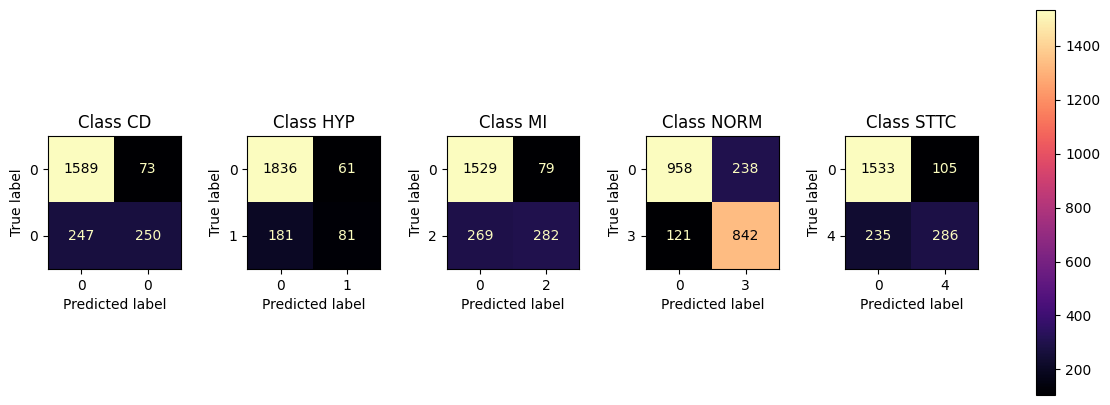

In [14]:
from scripts.data_evaluation import plot_confusion_matrix
import os

file_name = "confusion_matrix.png"
output_directory = f"saved_images/{model.model_name()}/"
if not os.path.exists(output_directory):
    os.makedirs(output_directory, exist_ok=True)

plot_confusion_matrix(
    y_test,
    y_pred,
    multi_label_binarizer.classes_,
    file_path=os.path.join(output_directory, file_name),
)

In [15]:
from sklearn.metrics import classification_report
import pandas as pd

print(
    classification_report(
        y_test, y_pred, target_names=list(multi_label_binarizer.classes_)
    )
)

              precision    recall  f1-score   support

          CD       0.77      0.50      0.61       497
         HYP       0.57      0.31      0.40       262
          MI       0.78      0.51      0.62       551
        NORM       0.78      0.87      0.82       963
        STTC       0.73      0.55      0.63       521

   micro avg       0.76      0.62      0.68      2794
   macro avg       0.73      0.55      0.62      2794
weighted avg       0.75      0.62      0.67      2794
 samples avg       0.66      0.65      0.64      2794



C:\Virtual Environments\ECG Anomaly Detection\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
report = classification_report(
    y_test, y_pred, target_names=list(multi_label_binarizer.classes_), output_dict=True
)
df = pd.DataFrame(report).transpose()
df.to_csv(f"saved_data/{model.model_name()}/classification_report.csv")

C:\Virtual Environments\ECG Anomaly Detection\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Show predictions on sample patient

In [17]:
class_names = np.array(multi_label_binarizer.classes_)

patient_ecg = np.expand_dims(X_test[0], axis=0)
patient_ecg_prob = (model.predict(patient_ecg) > threshold) * 1
sorted_categories = np.argsort(patient_ecg_prob[0])[:-6:-1]

for i in range(5):
    print(
        f"{class_names[sorted_categories[i]]}: {patient_ecg_prob[0][sorted_categories[i]]}"
    )

1/1 [==============================] - 0s 12ms/step
NORM: 1
STTC: 0
MI: 0
HYP: 0
CD: 0


In [100]:
sample_patients_predictions_df = pd.DataFrame()

for index in range(15):
    patient_ecg = np.expand_dims(X_test[index], axis=0)
    patient_ecg_prob = (model.predict(patient_ecg) > threshold) * 1
    sample_patients_predictions_df = pd.concat(
        [
            sample_patients_predictions_df,
            pd.DataFrame(
                data={
                    "Predicted": np.squeeze(patient_ecg_prob),
                    "True": y_test[index],
                    "---------": np.array(["-" for x in range(5)]),
                },
                index=class_names,
            ).transpose(),
        ]
    )

1/1 [==============================] - 0s 14ms/step


In [101]:
sample_patients_predictions_df

,CD,HYP,MI,NORM,STTC
Predicted,0,0,0,1,0
True,0,0,0,1,0
---------,-,-,-,-,-
Predicted,0,0,0,1,0
True,0,0,0,1,0
---------,-,-,-,-,-
Predicted,0,0,0,1,0
True,0,0,0,1,0
---------,-,-,-,-,-
Predicted,0,0,0,1,0
